In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from MPCProblem import MPCProblem
from util import *
import cvxpy as cp
import warnings
import itertools
import time
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
import graphviz
import pydotplus
from datetime import datetime
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.metrics import brier_score_loss
from scipy import stats
import matplotlib.dates as md
warnings.filterwarnings('ignore')

In [3]:
# Yuba friend function for LT
# change also perfect...
def MPC(Rmax, ramp_rate, NL, LT): # hefs_ep hefs exceendance probability

    # Rmax = 150 * kcfs_to_tafd # ~150,000 cfs
    # ramp_rate = 50 * kcfs_to_tafd # limit in either direction, per day ~5,000 cfs
    # this ramping value does not change the results much
    full_output = True
    
    run_synth = False
    site = 'ORDC1'
    # NL = 14 # could use up to 30
    start_date = '1996-12-01' 
    end_date = '1997-02-14' # model runs until (end_date - NL)
    
    df = pd.read_csv('data/Qobs.csv', index_col=0, parse_dates=True)
    df_median = calc_obs_medians(df) # for baseline only
    
    Q = df.loc[start_date:end_date, site].values * kcfs_to_tafd
    Q_median = df_median.loc[start_date:end_date, site].values * kcfs_to_tafd
    
    ds = xr.open_dataset('data/Qf-hefs.nc')
    da = ds['hefs'].sel(site=2, lead=slice(0,NL-1), ensemble=0, date=slice(start_date, end_date))
    Qf_hefs = da.values * kcfs_to_tafd # date, trace, lead

    # alter Qf_hefs....
    for t in range(len(Qf_hefs))[0:62]:
        Qf_hefs[t, :, (LT):14] = Q_median[(t+1+LT):(t+1+NL)] # replace forecast stuff with Q_median, LT = 15 means do nothing alteration
    
    
    NE, NL = Qf_hefs[0,:,:].shape
    
    problems = {'baseline': get_baseline_forecast(Q, Q_median, NL),
                'perfect': get_perfect_forecast_LT(Q, Q_median, NL, LT),
                'hefs': Qf_hefs}
    
    # synthetic forecasts - do not load until running
    if run_synth:
      # ds_syn = xr.open_dataset('data/Qf-syn.nc')
      ds_syn = xr.open_dataset('data/Qf-syn_pcnt=0.99_ORDC1_5fold.nc')
      da_syn = ds_syn['syn'].sel(site=2, lead=slice(0,NL-1), date=slice(start_date, end_date))
      num_syn = ds_syn['syn'].shape[-1]
    
      for i in range(num_syn):
        problems['syn_%d' % i] = None

    else:
      num_syn = 0
    
    res_df = pd.DataFrame({'Q': Q}, index=df.loc[start_date:end_date].index)

    # store P
    P_list = []
    for k in problems.keys():
    
      if 'syn' not in k:
        _Qf = problems[k]
      else:
        i = int(k.split('_')[1])
        _Qf = da_syn.sel(ensemble=i).values * kcfs_to_tafd
    
      P = MPCProblem(u_max = Rmax,
                     TOCS = np.zeros(NL),
                     Q = Q,
                     Qf = _Qf, 
                     ramp_rate = ramp_rate,
                     full_output = full_output)
    
      P.run(verbose=True)
      P_list.append(P)    
      res_df['R_%s' % k] = P.R
      res_df['S_%s' % k] = P.S
    
      if full_output:
        res_df['status_%s' % k] = P.status
        res_df['obj_%s' % k] = P.obj
        res_df['ESf_%s' % k] = P.Sf_post[:,:,-1].mean(axis=1)
        # can't save full uf,Sf in 2D dataframe

    
    # model only runs up to (end_date - NL)
    model_end_date = pd.to_datetime(end_date) -  pd.to_timedelta(14, unit='d')
    res_df = res_df[:model_end_date]
    # res_df.to_csv('test_results.csv')

    return res_df, P_list

In [6]:
# run the MPC and obtain results for the plot

from MPCParams import MPCParams

fontsize = 12
plt.rcParams.update({'font.size': fontsize})

site = 'ORDC1'
# NL = 14 # could use up to 30
start_date = '1996-12-01' 
end_date = '1997-02-14' # model runs until (end_date - NL)

# Parameters
Rmax = 150 * kcfs_to_tafd
ramp_rate = 50 * kcfs_to_tafd
LT = 14
NL = 14
hefs_ep = 0

# load data
df = pd.read_csv('data/Qobs.csv', index_col=0, parse_dates=True)
df_median = calc_obs_medians(df) # for baseline only

Q = df.loc[start_date:end_date, site].values * kcfs_to_tafd
Q_median = df_median.loc[start_date:end_date, site].values * kcfs_to_tafd

ds = xr.open_dataset('data/Qf-hefs.nc')
da = ds['hefs'].sel(site=2, lead=slice(0,NL-1), ensemble=0, date=slice(start_date, end_date))
Qf_hefs = da.values * kcfs_to_tafd # date, trace, lead

Qf_hefs = mess_around * Qf_hefs

# alter Qf_hefs....
for t in range(len(Qf_hefs))[0:62]:
    Qf_hefs[t, :, (LT):14] = Q_median[(t+1+LT):(t+1+NL)] # replace forecast stuff with Q_median, LT = 15 means do nothing alteration



# new function for sensitivity analysis
res_df, P_list = MPC(Rmax, ramp_rate, NL, LT)

# res_df adjust one day
res_df.index = res_df.index + pd.Timedelta(days = +1)

res_df.index.name = None

S_hefs_plot = res_df['S_hefs']
S_hefs_plot.index = S_hefs_plot.index + pd.Timedelta(days = -1)

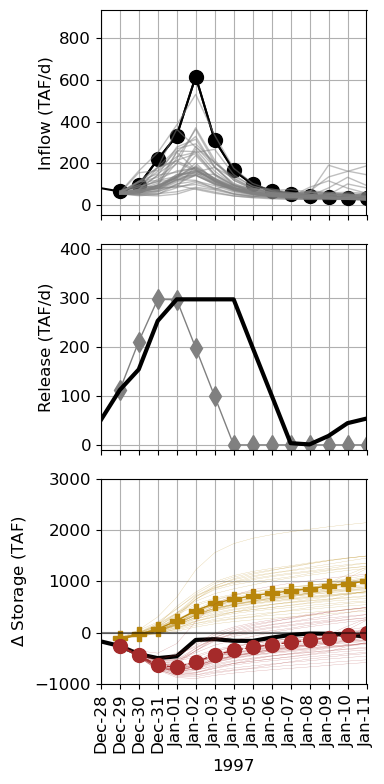

In [8]:
# visualizing the results. two of the following can be changed:

# 1. the manuscript figure is plotting t = 27 (Dec 28, 1996) as an example
t = 27

# 2. this can generate results for the three policies: (a) policy = 'hefs' (b) policy = 'perfect' (c) policy = 'baseline'
policy = 'hefs'


plt.rcParams.update({'font.size': 12})



# fig, ax = plt.subplots(3, 1, figsize = (8,8), sharex = True)
fig, ax = plt.subplots(3, 1, figsize = (4,8), sharex = True)


start_date = '1996-12-01' 
end_date = '1997-02-14'


# create datetime index for the entire analysis period
start_date_format = pd.to_datetime(start_date) + pd.Timedelta(days = 0)
end_date_format = pd.to_datetime(start_date) + pd.Timedelta(days = 0)
date_index = pd.date_range(start_date, end_date)

# create datetime index for the 14 days window
# hefs time seriesstart date should be start day + 1
hefs_start_date = start_date_format + pd.Timedelta(days = t-0)

# create dataframe for the 14 days window using hefs start date and end date
df_Qf_hefs = pd.DataFrame(index = pd.date_range(hefs_start_date + pd.Timedelta(days = 1), 
                                                hefs_start_date + pd.Timedelta(days = 14)))

# get hefs values, 41 traces
for n in range(41):
    df_Qf_hefs['trace%s' %str(n)] = Qf_hefs[t, n, :]


##### plot the 14 days forecast window time series #####
# observed using t - t + 13, but hefs using t+1 to t+14
df_window = pd.DataFrame(index = pd.date_range(hefs_start_date + pd.Timedelta(days = 0), 
                                               hefs_start_date + pd.Timedelta(days = 14)))
# attach observed (perfect) and baseline trace
df_window['Q'] = Q[t:t+15]
df_window['Q_median'] = Q_median[t:t+15]

# plot the inflows: order is perfect, baseline then hefs


##### plot the entire analysis period time series for reference #####
df_plot = pd.DataFrame({"inflow": Q}, index = date_index)
df_plot.plot(ax = ax[0], color = 'black', alpha = 1, markersize = 10)
df_window['Q'].iloc[1::].plot(ax = ax[0], color = 'black', marker = "o", alpha = 1, markersize = 10)

# panel #2 plot forecast storage
df_fcst_stor = pd.DataFrame(index = pd.date_range(hefs_start_date + pd.Timedelta(days = 1), 
                                                hefs_start_date + pd.Timedelta(days = 14)))

P = P_list[1] # perfect

df_fcst_stor['Sf_pre_perfect'] = P.Sf_pre[t+1, 0, :]
df_fcst_stor['Sf_post_perfect'] = P.Sf_post[t+1, 0, :]

# plot the release on the third panel
df_fcst_stor['uf_perfect'] = P.uf[t, :]

# baseline
P = P_list[0] # baseline

df_fcst_stor['Sf_pre_baseline'] = P.Sf_pre[t+1, 0, :]
df_fcst_stor['Sf_post_baseline'] = P.Sf_post[t+1, 0, :]

# plot the release on the third panel
df_fcst_stor['uf_baseline'] = P.uf[t, :]

# HEFS
P = P_list[2]

# plot ensemble mean
Sf_pre_mean = np.mean(P.Sf_pre, axis = 1, keepdims = True)
Sf_post_mean = np.mean(P.Sf_post, axis = 1, keepdims = True)

df_fcst_stor['Sf_pre_hefs_mean'] = Sf_pre_mean[t+1, 0, :]
df_fcst_stor['Sf_post_hefs_mean'] = Sf_post_mean[t+1, 0, :]

# alternatively, plot ensemble max
Sf_pre_max = np.max(P.Sf_pre, axis = 1, keepdims = True)
Sf_post_max = np.max(P.Sf_post, axis = 1, keepdims = True)

df_fcst_stor['Sf_pre_hefs_max'] = Sf_pre_max[t+1, 0, :]
df_fcst_stor['Sf_post_hefs_max'] = Sf_post_max[t+1, 0, :]

# mean or max
mean_or_max = "mean"

df_fcst_stor['uf_hefs'] = P.uf[t, :]


axe_S = ax[2]
axe_R = ax[1]

# plot earlier ^^
# shift S_hefs one time step forward
                                           
# plot release on secondary axis
df_fcst_stor['uf_%s' %policy].plot(color = 'gray', linewidth = 1, marker = "d", ax = axe_R, alpha = 1, markersize = 10) # release

# plot hefs traces
if policy == 'hefs':

    # plot hefs traces...
    df_Qf_hefs[df_Qf_hefs.columns[0::]].plot(ax = ax[0], color = 'gray', alpha = 0.5, legend = False, linewidth = 1.0)

    
    S_hefs_plot.loc[df_window.index].plot(ax = axe_S, color = 'black', alpha = 1, linewidth = 3)
    df_fcst_stor['Sf_pre_hefs_%s' %(mean_or_max)].plot(color = 'darkgoldenrod', linewidth = 1,  ax = axe_S,
                                           marker = "P", markersize = 10)
    df_fcst_stor['Sf_post_hefs_%s' %(mean_or_max)].plot(color = 'brown', linewidth = 1, 
                                           linestyle = "--", marker = "o", ax = axe_S, markersize = 10)
    
    for n in range(len(P.Sf_pre[0])):
        df_fcst_stor['Sf_pre_hefs_trace%s' %str(n)] = P.Sf_pre[t+1, n, :]
        df_fcst_stor['Sf_post_hefs_trace%s' %str(n)] = P.Sf_post[t+1, n, :]
    
        df_fcst_stor['Sf_pre_hefs_trace%s' %str(n)].plot(ax = axe_S, color = 'darkgoldenrod',
                                                      linewidth = 0.2, alpha = 0.5)
        df_fcst_stor['Sf_post_hefs_trace%s' %str(n)].plot(ax = axe_S, color = 'brown',
                                                      linewidth = 0.2, alpha = 0.5)
else:
    df_window_copy.loc['1996-12-28'] = np.nan
    if policy == 'perfect':
        df_window_copy['Q'].plot(ax = ax[0], color = 'red', marker = "^", alpha = 1, markersize = 10) # perfect, red ^
        
    if policy == 'baseline':
        df_window_copy['Q_median'].plot(ax = ax[0], color = 'blue', markersize = 10, marker = "d") # baseline, blue diamond
        
    
    S_plot = res_df['S_%s' %policy].copy()
    S_plot.index = S_plot.index + pd.Timedelta(days = -1)
    S_plot.loc[df_window.index].plot(ax = axe_S, color = 'black', alpha = 1, linewidth = 3)
    df_fcst_stor['Sf_pre_%s' %policy].plot(color = 'darkgoldenrod', linewidth = 1,  ax = axe_S,
                                           marker = "P", markersize = 10)
    df_fcst_stor['Sf_post_%s' %policy].plot(color = 'brown', linewidth = 1, 
                                           linestyle = "--", marker = "o", ax = axe_S, markersize = 10)
   

res_df['R_%s' %policy].loc[df_window.index].plot(ax = axe_R, color = 'black', alpha = 1, markersize = 10, linewidth = 3)

# legend and other settings for panel #1    
ax[0].legend(['observed','%s' %policy])
ax[0].set_ylabel('Inflow (TAF/d)')
ax[0].set_ylim(-50, Qf_hefs.max())

# legend and other settings for panel #2
axe_S.legend(['Sf_pre mean', 
              'Sf_post mean',
              'final $\Delta$ storage'], ncol = 1)

axe_S.set_ylim(-1000,3000)


axe_S.axhline(0, color = 'black', alpha = 0.5)
axe_S.set_ylabel("$\Delta$ Storage (TAF)")
axe_S.set_xlabel('Lead Time (day)')

# legend and other settings for panel #3
axe_R.legend(['MPC horizon release policy', 'final release policy'])
axe_R.set_ylim(-10,410)
axe_R.set_ylabel('Release (TAF/d)')

df_window_copy = df_window.copy()

# add vertical line for time step
for x in range(3):
    ax[x].axvline(hefs_start_date, color = 'gray')

    axe = ax[x]
    axe.set_xticks(df_window_copy.index)
    axe.set_xticklabels(df_window_copy.index.strftime("%b-%d"), rotation = 90)
    axe.set_xlabel('1997')
    axe.grid()
    axe.legend().set_visible(False)
        
plt.tight_layout()